# Quora Question Pairs - Data Preprocessing

This notebook handles data cleaning, feature engineering, and preparation for modeling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from pathlib import Path
import joblib

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split

# Progress bar
from tqdm.auto import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

In [2]:
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

print("NLTK data downloaded successfully!")

NLTK data downloaded successfully!


## Load Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir = Path('drive/MyDrive/Colab Notebooks/data/Quora_duplicates')

train_df = pd.read_csv(data_dir / 'quora_question_pairs_train.csv.zip', index_col=0)
test_df = pd.read_csv(data_dir / 'quora_question_pairs_test.csv.zip', index_col=0)

train_df.head()

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
332278,459256,459257,The Iliad and the Odyssey in the Greek culture?,How do I prove that the pairs of three indepen...,0
196656,297402,297403,What is practical management and what is strat...,What are the practical aspects of strategic ma...,0
113125,184949,184950,How useful is MakeUseOf Answers?,Is there any Q&A site that is not Yahoo answer...,0
266232,101283,163744,Which is the best place to reside in India and...,Which ia the best place to visit in India?,0
122738,17811,27517,Why do so many people ask questions on Quora t...,Why don't many people posting questions on Quo...,1


## Duplicates

In [5]:
print(f"Train duplicates: {train_df.duplicated().sum()}")
print(f"Test duplicates: {test_df.duplicated().sum()}")

Train duplicates: 0
Test duplicates: 0


There are no duplicated rows in datasets.

## Missing Values

In [6]:
print("Missing Values in Train:")
missing_train = train_df.isnull().sum()
print(missing_train[missing_train > 0])

print("\n Missing Values in Test:")
missing_test = test_df.isnull().sum()
print(missing_test[missing_test > 0])

Missing Values in Train:
question1    1
question2    2
dtype: int64

 Missing Values in Test:
Series([], dtype: int64)


There are only 3 rows with missing values in train dataset, we can remove them.

In [7]:
train_df = train_df.dropna(subset=['question1', 'question2'])
train_df.isnull().sum()

,0
qid1,0
qid2,0
question1,0
question2,0
is_duplicate,0


## Text Preprocessing

In [8]:
def clean_text(text):
    """
    Basic text cleaning:
    - Convert to lowercase
    - Remove punctuation
    - Remove extra whitespace
    """
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = str(text).lower()

    # Remove punctuation
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text


def preprocess_text(text, remove_stopwords=True, stemming=True):
    """
    Advanced text preprocessing:
    - Clean text
    - Tokenize
    - Remove stopwords (optional)
    - Lemmatize (optional)
    """
    cleaned = clean_text(text)

    if not cleaned:
        return ""

    tokens = word_tokenize(cleaned)

    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]

    if stemming:
        stemmer = SnowballStemmer('english')
        tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(tokens)

In [9]:
train_df['question1_clean'] = train_df['question1'].progress_apply(preprocess_text)
train_df['question2_clean'] = train_df['question2'].progress_apply(preprocess_text)

print("\nExample 1:")
print(f"Original Q1: {train_df.iloc[0]['question1']}")
print(f"Cleaned Q1: {train_df.iloc[0]['question1_clean']}")
print(f"Original Q2: {train_df.iloc[0]['question2']}")
print(f"Cleaned Q2: {train_df.iloc[0]['question2_clean']}")

print("\nExample 15:")
print(f"Original Q1: {train_df.iloc[14]['question1']}")
print(f"Cleaned Q1: {train_df.iloc[14]['question1_clean']}")
print(f"Original Q2: {train_df.iloc[14]['question2']}")
print(f"Cleaned Q2: {train_df.iloc[14]['question2_clean']}")

  0%|          | 0/323429 [00:00<?, ?it/s]

  0%|          | 0/323429 [00:00<?, ?it/s]


Example 1:
Original Q1: The Iliad and the Odyssey in the Greek culture?
Cleaned Q1: iliad odyssey greek cultur
Original Q2: How do I prove that the pairs of three independent variables is also independent?
Cleaned Q2: prove pair three independ variabl also independ

Example 15:
Original Q1: What can I do when I can't remember my Apple ID password but can't get the email either?
Cleaned Q1: rememb appl id password get email either
Original Q2: I forgot my Apple ID and Password, what should I do?
Cleaned Q2: forgot appl id password


## Feature Engineering

In [10]:
def set_text_features(df):
    df = df.copy()
    # Length features
    df['q1_len'] = df['question1_clean'].apply(len)
    df['q2_len'] = df['question2_clean'].apply(len)
    df['len_diff'] = abs(df['q1_len'] - df['q2_len'])
    df['len_ratio'] = df[['q1_len', 'q2_len']].min(axis=1) / (df[['q1_len', 'q2_len']].max(axis=1) + 1)

    # Word count features
    df['q1_words'] = df['question1_clean'].apply(lambda x: len(x.split()))
    df['q2_words'] = df['question2_clean'].apply(lambda x: len(x.split()))
    df['word_diff'] = abs(df['q1_words'] - df['q2_words'])
    df['word_ratio'] = df[['q1_words', 'q2_words']].min(axis=1) / (df[['q1_words', 'q2_words']].max(axis=1) + 1)

    # Common words
    def count_common_words(row):
        q1_words = set(row['question1_clean'].split())
        q2_words = set(row['question2_clean'].split())
        return len(q1_words.intersection(q2_words))

    df['common_words'] = df.progress_apply(count_common_words, axis=1)
    df['common_words_ratio'] = df['common_words'] / (df['q1_words'] + df['q2_words'] + 1)

    # Unique words
    def count_unique_words(row):
        q1_words = set(row['question1_clean'].split())
        q2_words = set(row['question2_clean'].split())
        return len(q1_words.union(q2_words))

    df['unique_words'] = df.progress_apply(count_unique_words, axis=1)

    return df

In [11]:
print("Set text features for train data...")
train_processed = set_text_features(train_df)

print(f"\nProcessed dataset shape: {train_processed.shape}")
display(pd.DataFrame({"Processed features": train_processed.columns.tolist()}))

Set text features for train data...


  0%|          | 0/323429 [00:00<?, ?it/s]

  0%|          | 0/323429 [00:00<?, ?it/s]


Processed dataset shape: (323429, 18)


,Processed features
0,qid1
1,qid2
2,question1
3,question2
4,is_duplicate
5,question1_clean
6,question2_clean
7,q1_len
8,q2_len
9,len_diff


In [12]:
feature_cols = train_processed.columns.difference(train_df.columns).tolist()

In [13]:
print(feature_cols)

['common_words', 'common_words_ratio', 'len_diff', 'len_ratio', 'q1_len', 'q1_words', 'q2_len', 'q2_words', 'unique_words', 'word_diff', 'word_ratio']


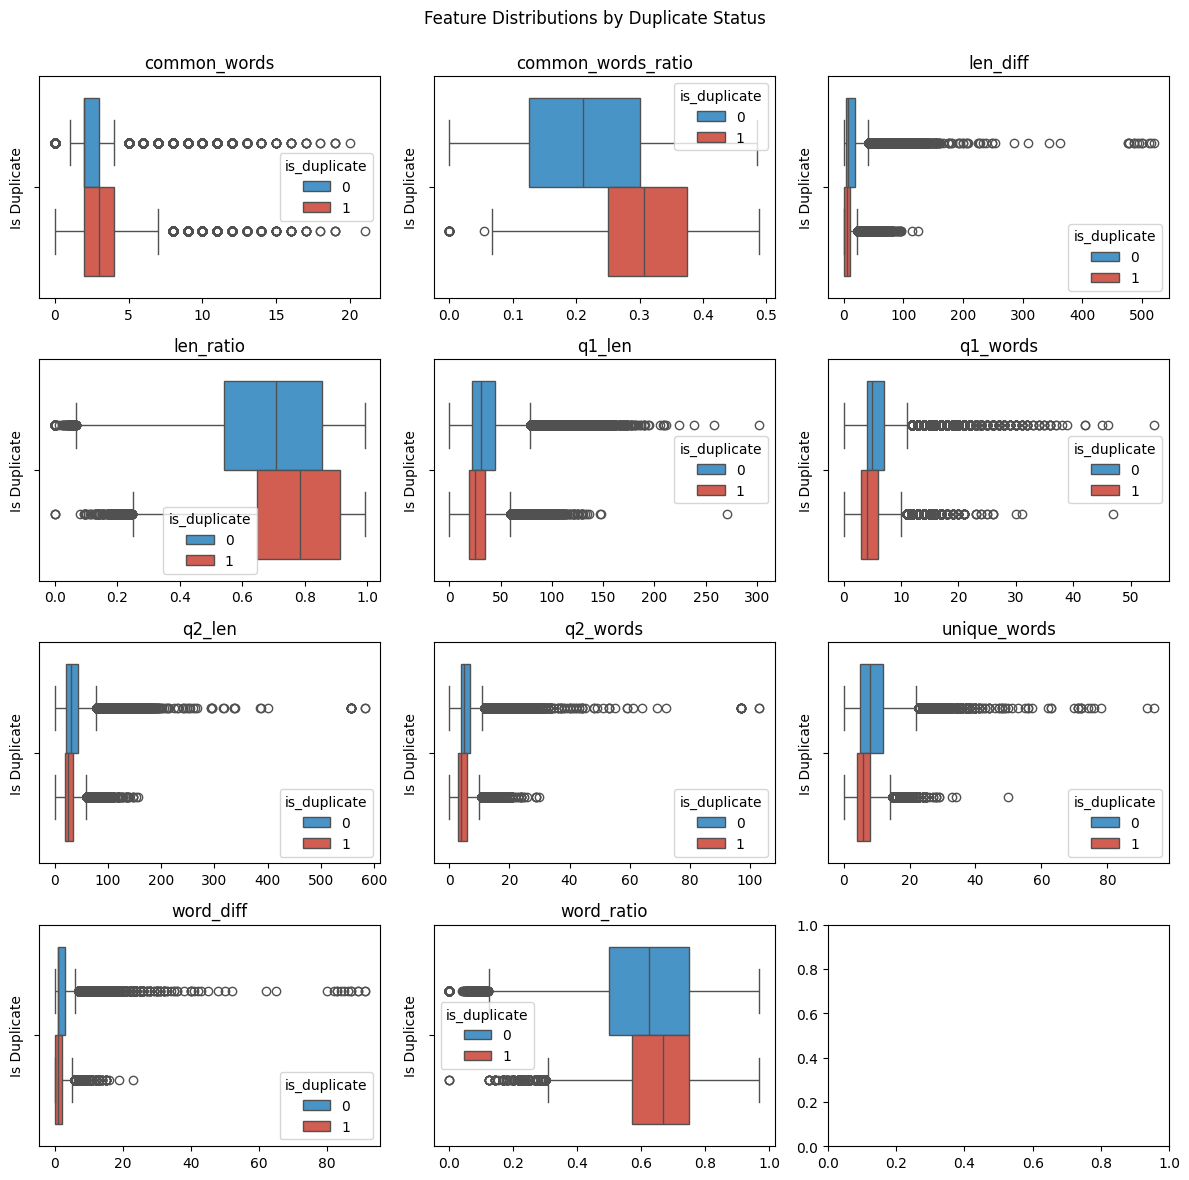

In [14]:
fig, axes = plt.subplots(4, 3, figsize=(12, 12))
axes = axes.ravel()
palette = {0: '#3498db', 1: '#e74c3c'}

plt.suptitle('Feature Distributions by Duplicate Status\n')
for i, col in enumerate(feature_cols):
    sns.boxplot(train_processed,
                 x=col, hue='is_duplicate',
                 ax=axes[i],
                 palette=palette)
    axes[i].set_title(f'{col}')
    axes[i].set_ylabel('Is Duplicate')
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

Duplicates (red) have:
- more common words between Q1 and Q2
- smaller length differences
- smaller word-count differences
- fewer unique words

Most Predictive Features:
- common_words
- common_words_ratio
- len_diff
- word_diff
- word_ratio

## Splitting Data (Train/Validation)

In [15]:
train_final_df, val_final_df = train_test_split(
    train_processed,
    test_size=0.2,
    random_state=42,
    stratify=train_processed["is_duplicate"]
)

## Process Test Data

In [16]:
print("\nPreprocessing test data...")
test_final_df = test_df.copy()

test_final_df['question1_clean'] = test_final_df['question1'].progress_apply(preprocess_text)
test_final_df['question2_clean'] = test_final_df['question2'].progress_apply(preprocess_text)

print("\nExtracting basic features for test data...")
test_final_df = set_text_features(test_final_df)


Preprocessing test data...


  0%|          | 0/80858 [00:00<?, ?it/s]

  0%|          | 0/80858 [00:00<?, ?it/s]


Extracting basic features for test data...


  0%|          | 0/80858 [00:00<?, ?it/s]

  0%|          | 0/80858 [00:00<?, ?it/s]

## Save Preprocessed Data

In [19]:
processed_dir = Path('drive/MyDrive/Colab Notebooks/data/Quora_duplicates/processed_data')

train_final_df.to_csv(processed_dir / 'train_processed.csv.zip', index=False, compression='zip')
val_final_df.to_csv(processed_dir / 'val_processed.csv.zip', index=False, compression='zip')
test_final_df.to_csv(processed_dir / 'test_processed.csv.zip', index=False, compression='zip')

feature_names = {'feature_cols': feature_cols}
joblib.dump(feature_names, processed_dir / 'feature_names.joblib')

print("All files saved to:", processed_dir)

All files saved to: drive/MyDrive/Colab Notebooks/data/Quora_duplicates/processed_data
